In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [252]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [253]:
filename = os.path.join(os.getcwd(), "dataframes", "actReading_11.csv")
actReading_11_df = pd.read_csv(filename, header = 0)


In [254]:
actReading_11_df.shape
actReading_11_df.columns


Index(['studentId', 'is_proficient', 'proficient_score', 'course_ACT Review',
       'course_ACT/WK Rev.', 'course_ACTReview.5C', 'course_AG Communica',
       'course_AIDE-ELEM', 'course_AIDE-LIB', 'course_ALG I B ACCE',
       ...
       'course_YearbkII9-12', 'course_Yearbook9-12', 'course_YrbkIII9-12',
       'school_High School A', 'school_High School B', 'school_High School C',
       'school_High School D', 'iready_math', 'iready_reading',
       'bbb_literacy'],
      dtype='object', length=241)

In [255]:
#doing PCA to get the columns that are impacted most by proficient_score label 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(actReading_11_df.drop(columns=['proficient_score', 'is_proficient']))
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = 0
components = 0

for variance in explained_variance_ratio:
    cumulative_sum += variance
    components += 1
    if cumulative_sum >= 0.80:  # Adjust to your threshold (80%)
        break

print(f"Number of components needed: {components}")
print(f"Cumulative explained variance: {cumulative_sum}")



Number of components needed: 107
Cumulative explained variance: 0.8014293611549197


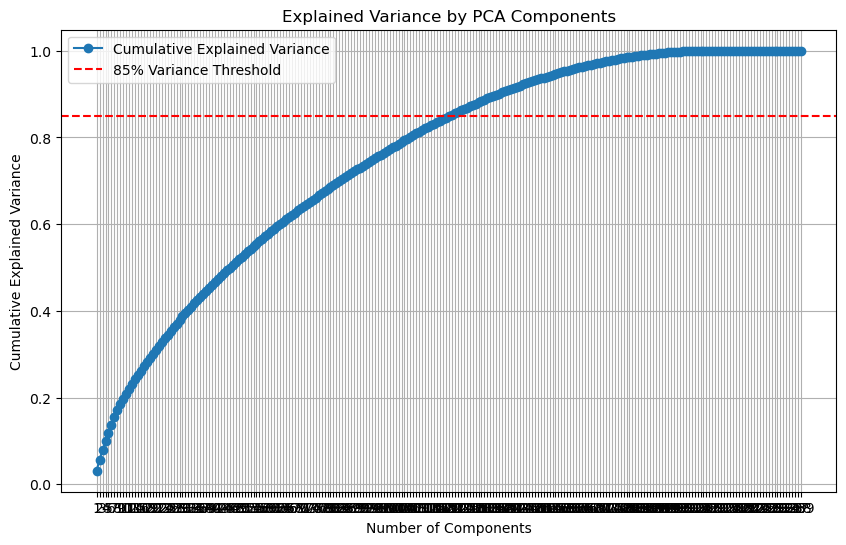

Number of components needed: 121


In [256]:
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='85% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

# Calculate the number of components needed to explain at least 85% variance
components = np.argmax(cumulative_variance >= 0.85) + 1  # Add 1 to get the count of components
print(f"Number of components needed: {components}")

In [257]:
components = pca.components_[:107]  # First 18 principal components

# Create a DataFrame for feature loadings
feature_loadings_df = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])],
                                    index = actReading_11_df.drop(columns=['proficient_score','is_proficient']).columns)

# Find the most important features for each principal component
top_features = {}

for pc in feature_loadings_df.columns:
    # Get the absolute values of the loadings and sort them
    sorted_features = feature_loadings_df[pc].abs().sort_values(ascending=False)
    # Select the top 5 features (you can adjust this number)
    top_features[pc] = sorted_features.head(5).index.tolist()

# Display the top features for each principal component
for pc, features in top_features.items():
    print(f'Top features for {pc}: {features}')

Top features for PC1: ['course_HEALTH 9-12', 'course_DRIVERS ED', 'course_D&TSafetyEd', 'course_Health 9-12', 'school_High School B']
Top features for PC2: ['studentId', 'course_Physical Sci', 'course_English Gr10', 'course_Algebra I B', 'course_USHis I G10']
Top features for PC3: ['course_Eng Gr10 Adv', 'course_ChemistryAdv', 'course_USHis I Adv', 'course_Panther Adv', 'school_High School A']
Top features for PC4: ['course_Ess II:USHis', 'course_Ess: Phy Sci', 'course_Eng Ess 10', 'course_Alg Esntls B', 'course_RdIntrv7-12']
Top features for PC5: ['school_High School A', 'course_Panther Adv', 'course_USHis I Adv', 'school_High School B', 'course_Eng Gr10 Adv']
Top features for PC6: ['course_PhySciACCESS', 'course_EnglGr10ACCE', 'course_HealthACCESS', 'course_USHisIG10ACC', 'course_AlgII/TrigAC']
Top features for PC7: ['course_Ess: E & SS', 'course_TranSer 11', 'course_EssIII:USHis', 'course_Eng Ess 11', 'course_Geo Ess']
Top features for PC8: ['school_High School D', 'school_High Scho

In [258]:
print(actReading_11_df.dtypes)

studentId                 int64
is_proficient              bool
proficient_score        float64
course_ACT Review          bool
course_ACT/WK Rev.         bool
course_ACTReview.5C        bool
course_AG Communica        bool
course_AIDE-ELEM           bool
course_AIDE-LIB            bool
course_ALG I B ACCE        bool
course_ALIITRIGH/A         bool
course_ARMY LET I          bool
course_ARMY LET II         bool
course_ARMY LET III        bool
course_ARMY LET IV         bool
course_ARMYLETIVACT        bool
course_AcAdv.Baseba        bool
course_AcAdv.Basket        bool
course_AcAdv.CrossC        bool
course_AcAdv.Footb         bool
course_AcAdv.Softba        bool
course_AcAdv.Volley        bool
course_Accounting          bool
course_Adv BTA             bool
course_Advanced Agr        bool
course_Agriscience         bool
course_Alg Esntls B        bool
course_Alg II/Trig         bool
course_AlgEnrichmet        bool
course_AlgII/TrigAC        bool
course_Algebra I           bool
course_A

In [259]:
#changing all bools to ints 0 and 1 for the model
actReading_11_df[actReading_11_df.select_dtypes(include=['bool']).columns] = actReading_11_df.select_dtypes(include=['bool']).astype(int)
actReading_11_df.dtypes

studentId                 int64
is_proficient             int32
proficient_score        float64
course_ACT Review         int32
course_ACT/WK Rev.        int32
course_ACTReview.5C       int32
course_AG Communica       int32
course_AIDE-ELEM          int32
course_AIDE-LIB           int32
course_ALG I B ACCE       int32
course_ALIITRIGH/A        int32
course_ARMY LET I         int32
course_ARMY LET II        int32
course_ARMY LET III       int32
course_ARMY LET IV        int32
course_ARMYLETIVACT       int32
course_AcAdv.Baseba       int32
course_AcAdv.Basket       int32
course_AcAdv.CrossC       int32
course_AcAdv.Footb        int32
course_AcAdv.Softba       int32
course_AcAdv.Volley       int32
course_Accounting         int32
course_Adv BTA            int32
course_Advanced Agr       int32
course_Agriscience        int32
course_Alg Esntls B       int32
course_Alg II/Trig        int32
course_AlgEnrichmet       int32
course_AlgII/TrigAC       int32
course_Algebra I          int32
course_A

In [260]:
actReading_11_df_copy1 = actReading_11_df.drop([ 'studentId'], axis=1).copy()
actReading_11_df_copy1.head(10)

,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,course_VarFBII,course_VarFBIII,

In [261]:
proficient_score = actReading_11_df_copy1['proficient_score'].describe()[['min','max']]
print(proficient_score)

min    0.222222
max    1.972222
Name: proficient_score, dtype: float64


In [262]:
#Create Training and Test Data
yRead = actReading_11_df_copy1['proficient_score']
XRead= actReading_11_df_copy1.drop(['proficient_score','is_proficient'], axis=1)
print("Number of examples: " + str(XRead.shape[0]))

X_trainRead,X_testRead, y_trainRead,y_testRead  = train_test_split(XRead,yRead, test_size=0.20,stratify = actReading_11_df_copy1['is_proficient'],random_state=123)
print(X_trainRead.shape)
print(X_testRead.shape)

#possible hyperparameters
max_depth_valuesRead = [8,12,25,32]
min_samples_leaf_valuesRead = [4,5,8,10]
param_gridRead = {'max_depth' : list(max_depth_valuesRead), 'min_samples_leaf' : list(min_samples_leaf_valuesRead)}


Number of examples: 2578
(2062, 238)
(516, 238)


In [263]:
#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressorRead = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_gridRead = GridSearchCV(dt_regressorRead, param_gridRead, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_searchRead = dt_gridRead.fit(X_trainRead, y_trainRead)

print("Done")
dt_best_paramsRead = dt_grid_searchRead.best_params_

dt_best_paramsRead

Running Grid Search
Done


{'max_depth': 32, 'min_samples_leaf': 4}

In [264]:
dt_modelRead = DecisionTreeRegressor(max_depth=32, min_samples_leaf=4)
dt_modelRead.fit(X_trainRead,y_trainRead)

#testing model on the X_test
y_dt_predRead = dt_modelRead.predict(X_testRead)
dt_rmseRead = mean_squared_error(y_testRead,y_dt_predRead,squared=False)
dt_r2Read = r2_score(y_testRead,y_dt_predRead)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_read_bool = y_dt_predRead >= threshold
y_test_read_bool = y_testRead >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_read_bool, y_pred_read_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmseRead))
print('[DT] R2: {0}'.format(dt_r2Read))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.90      0.78       289
        True       0.79      0.47      0.59       227

    accuracy                           0.71       516
   macro avg       0.74      0.69      0.69       516
weighted avg       0.73      0.71      0.70       516

[DT] Root Mean Squared Error: 0.2503344415922375
[DT] R2: 0.3741857096950486


Based on these metrics, model is having a difficult time with predicting if a student is actaully proficent. we know that most of the students are below proficentcy and that there is a class imbalance. 


In [265]:
#looking at the micro score
micro_f1 = f1_score(y_test_read_bool, y_pred_read_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7131782945736435


Confusion Matrix:
[[261  28]
 [120 107]]


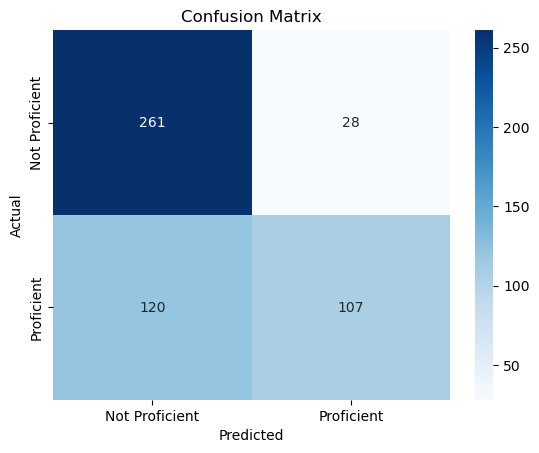

In [266]:
cm = confusion_matrix(y_test_read_bool, y_pred_read_bool)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, plot the confusion matrix using seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Proficient", "Proficient"], yticklabels=["Not Proficient", "Proficient"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#I am worried about the false positive but it seems low

Feature Importance

In [267]:
importances = dt_modelRead.feature_importances_
feature_names = X_trainRead.columns

# Combine names and importances, and sort
importance_dfRead = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_dfRead= importance_dfRead.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_dfRead)

                  Feature  Importance
76    course_Eng Gr10 Adv    0.339077
84      course_Enviro Sci    0.047374
158   course_Physical Sci    0.040050
177      course_Spanish 1    0.035955
220      course_Vocal I 1    0.034079
234  school_High School D    0.031744
29     course_Algebra I B    0.021377
208         course_VarFBI    0.020025
24     course_Alg II/Trig    0.018624
85    course_Ess II:USHis    0.017586
67     course_D&TSafetyEd    0.016106
142      course_Music App    0.016095
7      course_ALIITRIGH/A    0.014390
42    course_BandMarch.5C    0.014374
186      course_Theatre I    0.014296
111   course_HISTUS1877AC    0.013674
166     course_Psychology    0.011850
101   course_Fund Agrisci    0.010979
216    course_Vis Arts II    0.010879
117   course_IT Fndamntls    0.010769
56    course_CareerPrep-B    0.010235
104       course_Geometry    0.010161
183   course_StudyHall912    0.009820
131   course_LIFE PE 9-12    0.009538
64    course_Credit Recov    0.009527
96    course

In [268]:
importance_dfRead.head(50)

,Feature,Importance
76,course_Eng Gr10 Adv,0.339077
84,course_Enviro Sci,0.047374
158,course_Physical Sci,0.040050
177,course_Spanish 1,0.035955
220,course_Vocal I 1,0.034079
234,school_High School D,0.031744
29,course_Algebra I B,0.021377
208,course_VarFBI,0.020025
24,course_Alg II/Trig,0.018624
85,course_Ess II:USHis,0.017586


In [269]:
top_50_columns = importance_dfRead.columns[:50]

# Select the columns by name
top_50_columns_df = importance_dfRead[top_50_columns]